In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 6)

def show(title, img, cmap='gray'):
    plt.figure()
    plt.title(title)
    if img is None:
        print('Image is None')
        return
    plt.imshow(img, cmap=cmap)
    plt.axis('off')

def to_uint8(img):
    img = np.clip(img, 0, 255)
    return img.astype(np.uint8)

def add_salt_and_pepper(image, amount, salt_vs_pepper=0.5):
    noisy = image.copy()
    num_pixels = int(image.size * amount)
    xs = np.random.randint(0, image.shape[0], num_pixels)
    ys = np.random.randint(0, image.shape[1], num_pixels)
    choices = np.random.rand(num_pixels) < salt_vs_pepper
    noisy[xs[choices], ys[choices]] = 255
    noisy[xs[~choices], ys[~choices]] = 0
    return noisy

def add_gaussian_noise(image, mean=0.0, sigma=10.0):
    return to_uint8(image + np.random.normal(mean, sigma, image.shape))

def prewitt_edges(image):
    kernelx = np.array([[ -1, 0, 1],
                        [ -1, 0, 1],
                        [ -1, 0, 1]], dtype=np.float32)
    kernely = np.array([[ 1, 1, 1],
                        [ 0, 0, 0],
                        [-1,-1,-1]], dtype=np.float32)
    gx = cv2.filter2D(image, -1, kernelx)
    gy = cv2.filter2D(image, -1, kernely)
    mag = np.hypot(gx, gy)
    mag = to_uint8(mag / mag.max() * 255) if mag.max() != 0 else to_uint8(mag)
    return gx, gy, mag

def roberts_edges(img):
    kx = np.array([[1, 0], [0, -1]], dtype=np.float32)
    ky = np.array([[0, 1], [-1, 0]], dtype=np.float32)
    gx = cv2.filter2D(img.astype(np.float32), -1, kx)
    gy = cv2.filter2D(img.astype(np.float32), -1, ky)
    mag = np.hypot(gx, gy)
    mag = to_uint8(mag / mag.max() * 255) if mag.max() != 0 else to_uint8(mag)
    return gx, gy, mag


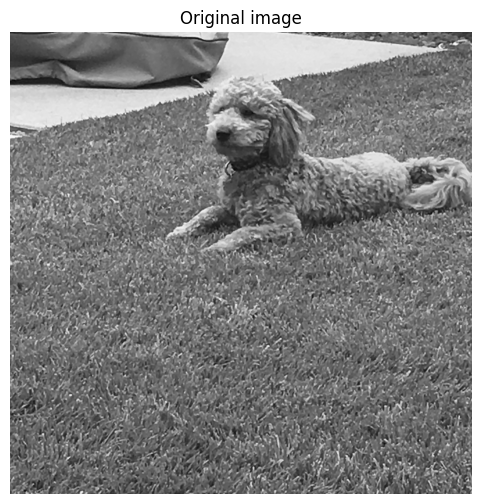

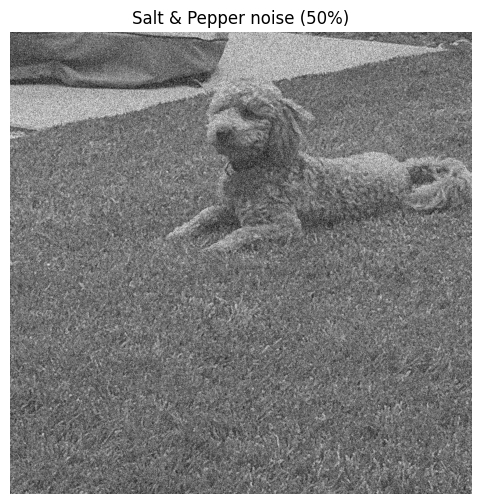

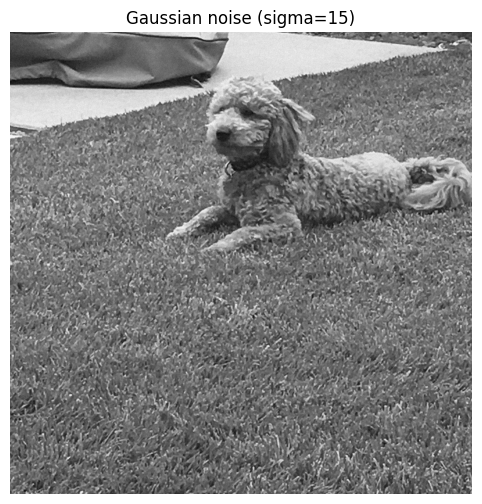

In [13]:
image = cv2.imread('images/outside.jpg', cv2.IMREAD_GRAYSCALE)

show('Original image', image)

sp_noisy = add_salt_and_pepper(image, amount=0.5, salt_vs_pepper=0.5)
show('Salt & Pepper noise (50%)', sp_noisy)

gauss_noisy = add_gaussian_noise(image, mean=0.0, sigma=15.0)
show('Gaussian noise (sigma=15)', gauss_noisy)

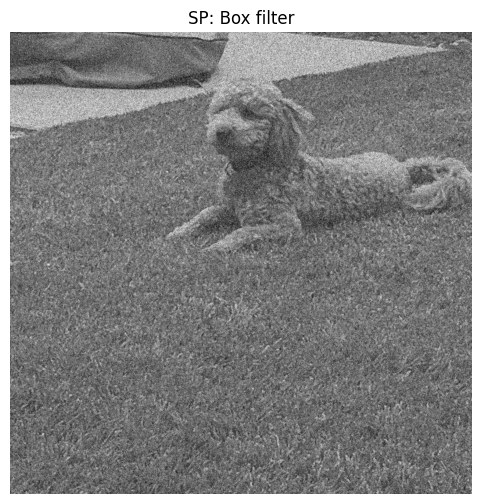

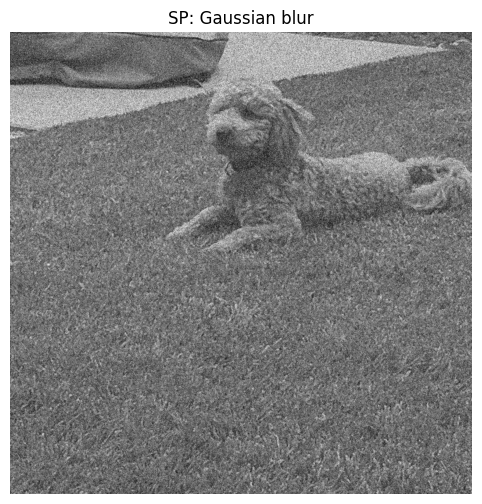

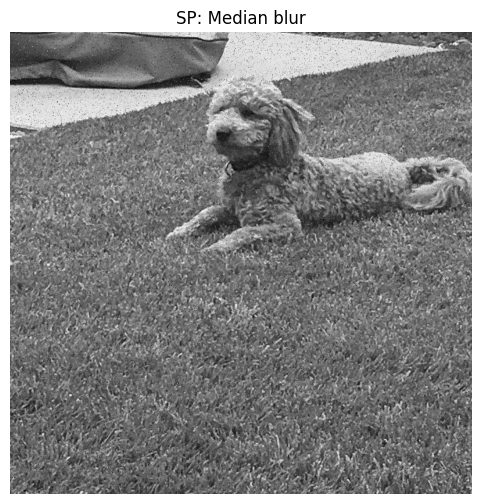

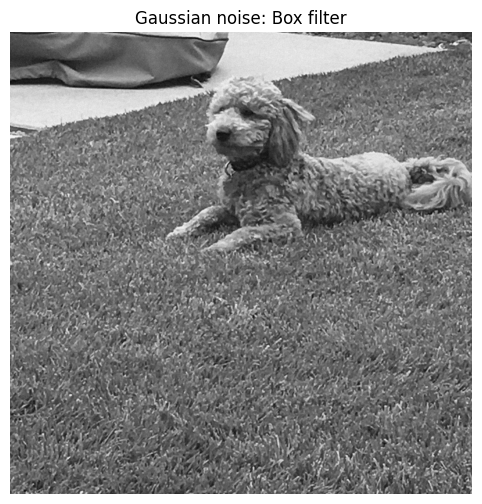

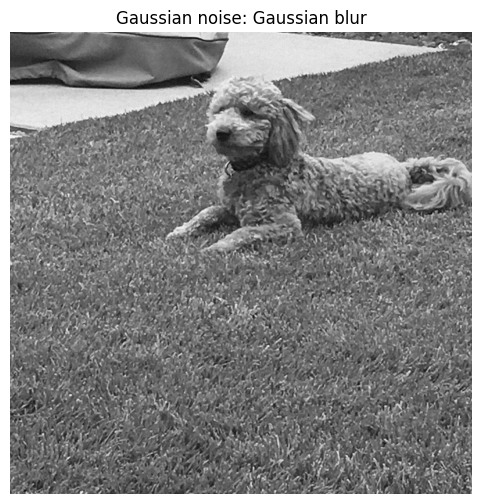

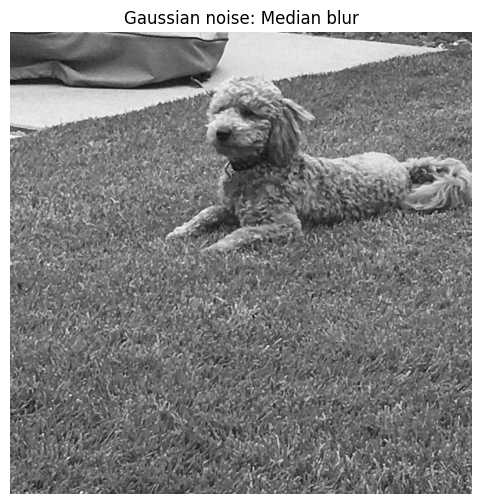

In [14]:
box_sp = cv2.blur(sp_noisy, (3,3))
gauss_sp = cv2.GaussianBlur(sp_noisy, (3,3), 0)
median_sp = cv2.medianBlur(sp_noisy, 3)

show('SP: Box filter', box_sp)
show('SP: Gaussian blur', gauss_sp)
show('SP: Median blur', median_sp)

box_g = cv2.blur(gauss_noisy, (3,3))
gauss_g = cv2.GaussianBlur(gauss_noisy, (3,3), 0)
median_g = cv2.medianBlur(gauss_noisy, 3)

show('Gaussian noise: Box filter', box_g)
show('Gaussian noise: Gaussian blur', gauss_g)
show('Gaussian noise: Median blur', median_g)


Median filter performs best for salt-and-pepper noise. Gaussian and box blur are better for Gaussian noise (Gaussian blur usually better than box filter)

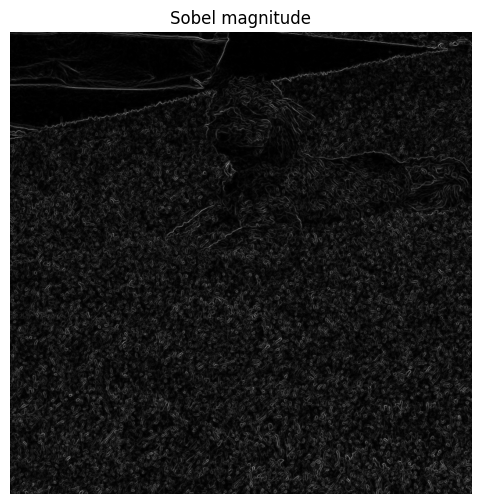

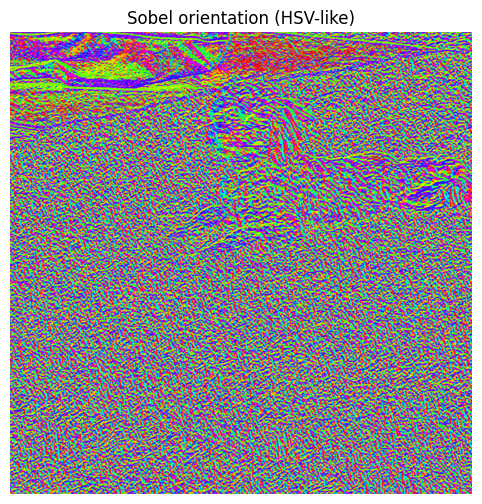

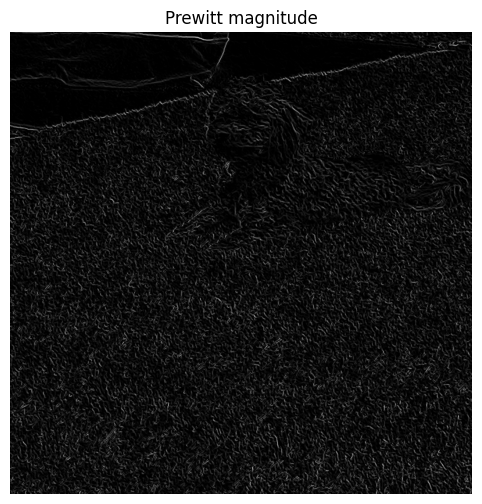

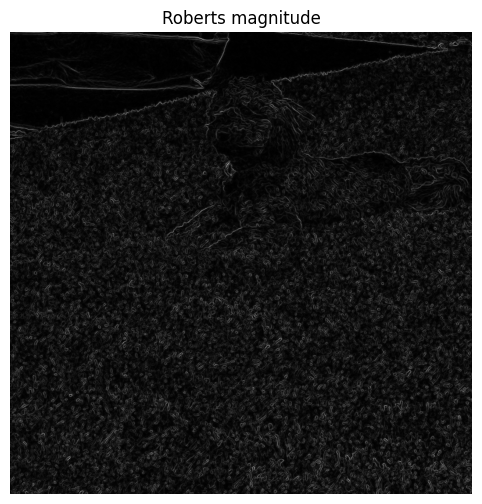

In [15]:
sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
sobel_mag = np.hypot(sobelx, sobely)
sobel_mag_u8 = to_uint8(sobel_mag / sobel_mag.max() * 255) if sobel_mag.max() != 0 else to_uint8(sobel_mag)

orientation = (np.arctan2(sobely, sobelx) * 180 / np.pi) % 360

show('Sobel magnitude', sobel_mag_u8)

plt.figure()
plt.title('Sobel orientation (HSV-like)')
plt.imshow(orientation, cmap='hsv')
plt.axis('off')

px, py, prewitt_mag = prewitt_edges(image)
show('Prewitt magnitude', prewitt_mag)

rx, ry, roberts_mag = roberts_edges(image)
show('Roberts magnitude', roberts_mag)


Sobel uses larger (3x3) kernels with smoothing effect; Prewitt is similar but slightly different kernel weights; Roberts is 2x2, detects diagonal gradients and is more sensitive to noise.

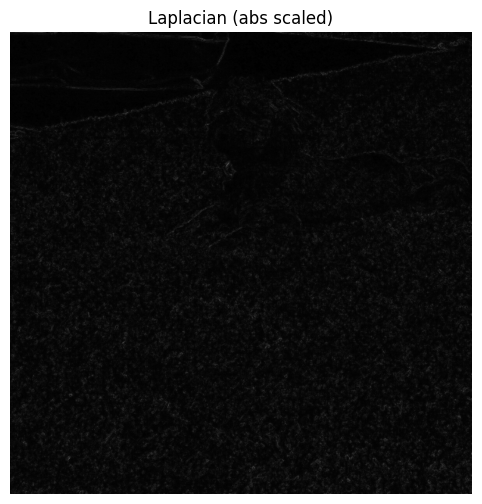

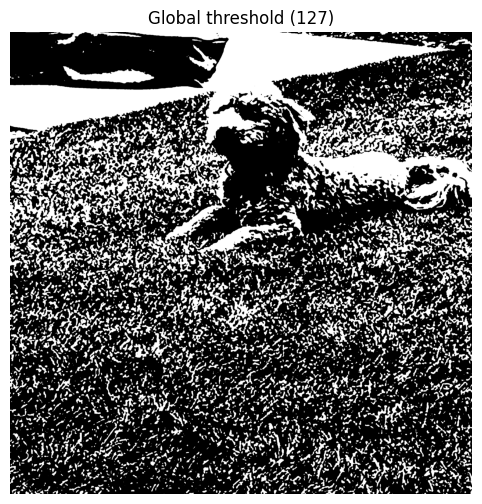

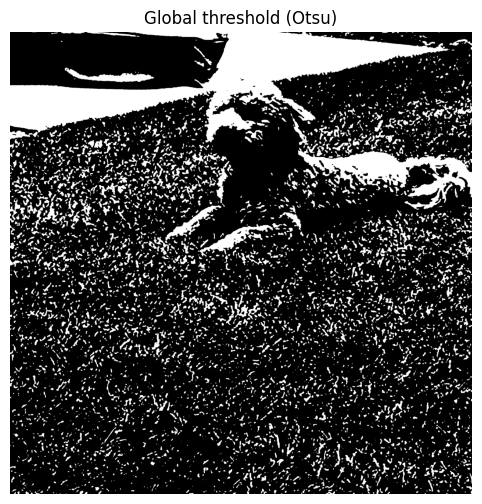

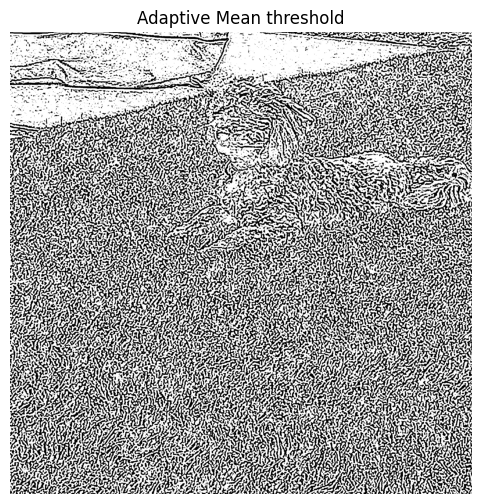

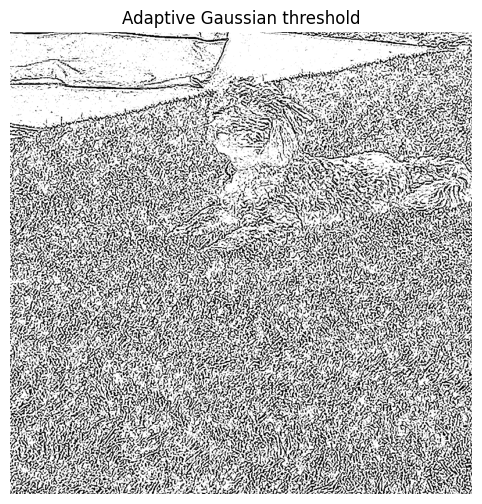

In [16]:
lap = cv2.Laplacian(image, cv2.CV_64F)
lap_u8 = to_uint8(np.abs(lap) / np.max(np.abs(lap)) * 255) if np.max(np.abs(lap)) != 0 else to_uint8(lap)
show('Laplacian (abs scaled)', lap_u8)

_, th_global = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
show('Global threshold (127)', th_global)

_, th_otsu = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
show('Global threshold (Otsu)', th_otsu)

th_adapt_mean = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                     cv2.THRESH_BINARY, 11, 2)
th_adapt_gauss = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                      cv2.THRESH_BINARY, 11, 2)

show('Adaptive Mean threshold', th_adapt_mean)
show('Adaptive Gaussian threshold', th_adapt_gauss)


Global thresholding works well when illumination is fairly uniform across the image; adaptive thresholding is useful when illumination varies locally (it computes thresholds per neighborhood).

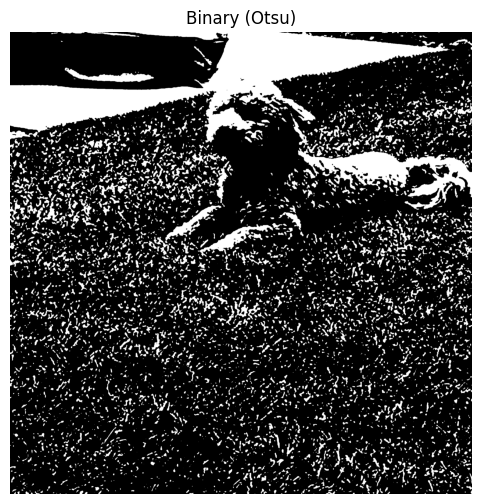

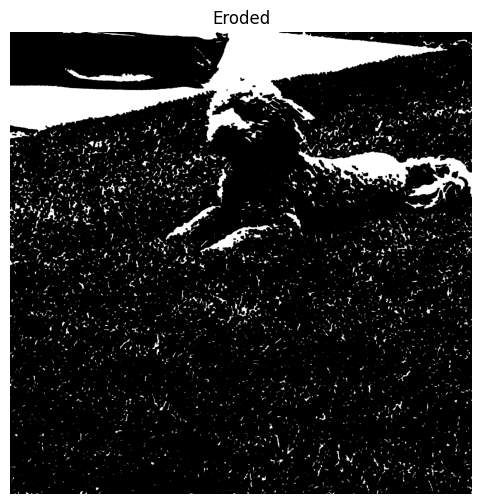

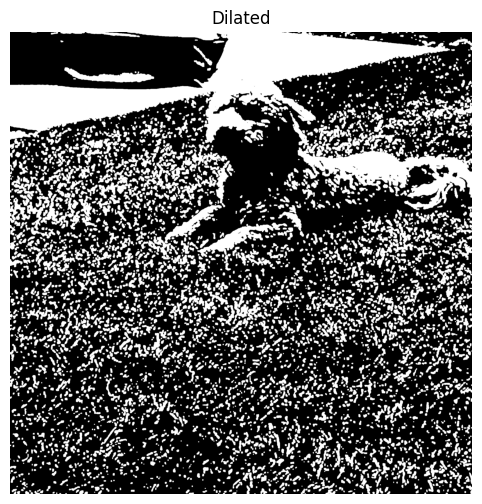

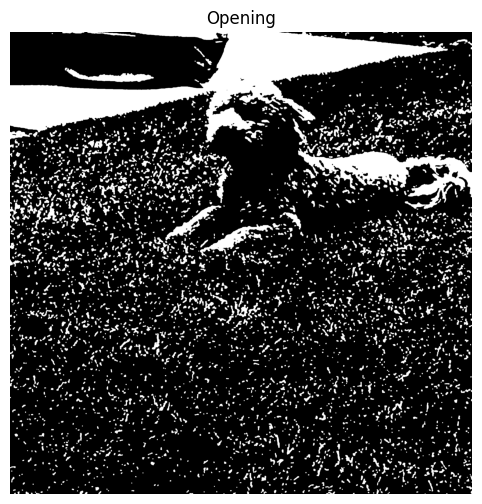

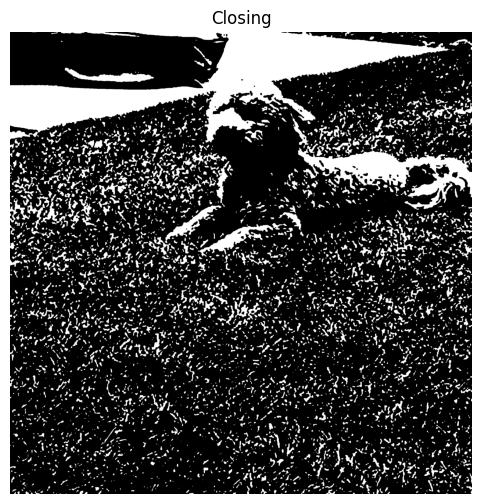

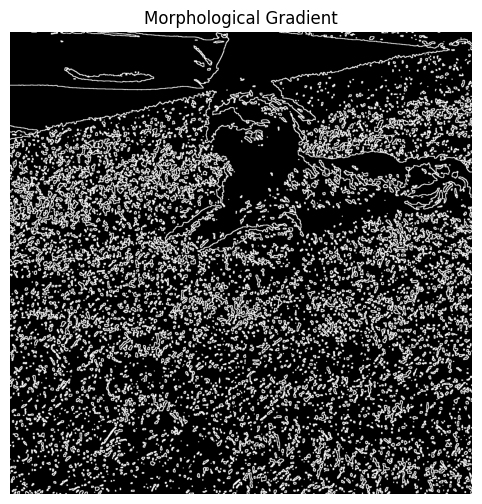

In [17]:
binary = th_otsu

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))

eroded = cv2.erode(binary, kernel, iterations=1)
dilated = cv2.dilate(binary, kernel, iterations=1)

opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
morph_grad = cv2.morphologyEx(binary, cv2.MORPH_GRADIENT, kernel)

show('Binary (Otsu)', binary)
show('Eroded', eroded)
show('Dilated', dilated)
show('Opening', opening)
show('Closing', closing)
show('Morphological Gradient', morph_grad)


These operations are useful for removing small noise (opening), closing small holes (closing), and extracting object boundaries (morphological gradient).